In [1]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746517 sha256=274f45769ab73bf602b292331b944cc711aefe0ae542c90137cc781d56db0888
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [2]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 20

In [3]:
import gdown

!gdown --fuzzy https://drive.google.com/file/d/1Ad5jP8r4Yl02B1_okrIFHwpSDD-8jk_Z/view?usp=drive_link -O images.jfif

Downloading...
From: https://drive.google.com/uc?id=1Ad5jP8r4Yl02B1_okrIFHwpSDD-8jk_Z
To: /content/images.jfif
100% 4.20k/4.20k [00:00<00:00, 10.2MB/s]


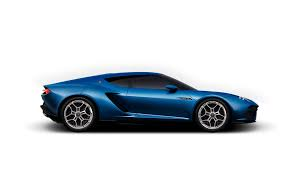

In [4]:
Image.open('images.jfif')

In [5]:
!mkdir images

# 1. Implement the non-parallel version of the shift function

In [6]:
%%timeit -r 1 -n 1
import os
import time
import numpy as np
from PIL import Image

H = 169
W = 298

IS_SAVE = True

if IS_SAVE:
    os.makedirs('images', exist_ok=True)

data = np.array(Image.open('images.jfif'))

def roll(arr):
    res = np.empty_like(arr)
    w = arr.shape[1]
    for i in range(w):
        res[:, (i + 1) % w] = arr[:, i]
    return res

for i in range(W):
    received = np.array_split(data, 1)[0]
    received_rolled = roll(received)
    data = np.array_split(np.concatenate([received_rolled, data[received.shape[0]:]]), 1)[0]

    if IS_SAVE:
        Image.fromarray(data).save(f'images/{i:0>5d}.jpg')

375 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# 2. Implement parallel MPI version using mpi4py (send and receive)

In [7]:
%%writefile shifted_img.py
import os
import time
import numpy as np
from PIL import Image
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_SAVE = True

H = 169
W = 298
numDataPerRank = H // size

data = None

if rank == 0:
    data = np.array(Image.open('images.jfif'))
    numDataPerRank =  H - (numDataPerRank * (size - 1))

if IS_SAVE:
    os.makedirs('images', exist_ok=True)

received = np.empty((numDataPerRank, W, 3), dtype=np.uint8)
sendcounts = np.array(comm.gather(received.size, 0))

def roll(arr):
    res = np.empty_like(arr)
    w = arr.shape[1]
    for i in range(w):
        res[:, (i + 1) % w] = arr[:, i]
    return res

for i in range(W):
    comm.Scatterv((data, sendcounts), received, root=0)
    received_rolled = roll(received)
    comm.Gatherv(received_rolled, (data, sendcounts), root=0)
    if rank == 0 and IS_SAVE:
        Image.fromarray(data).save(f'images/{i:0>5d}.jpg')

Writing shifted_img.py


In [8]:
!mpirun -n 1 --allow-run-as-root python3 shifted_img.py
print('MPI done')

MPI done


#3.  Create the animation

In [9]:
files = [f for f in os.listdir('images') if os.path.isfile(os.path.join('images', f))]
files.sort()

img, *imgs = [Image.open('images/' + f) for f in files]
img.save(fp="shifted_img.gif", format='GIF', append_images=imgs, save_all=True, duration=110, loop=0)

!rm -r images

In [10]:
time_arr = []
processes = range(1, 11)
for i in processes:
    print(f'Num of processes {i}:\n', end='')
    t = %timeit -o -r 1 -n 1 !mpirun -n {i} --oversubscribe --allow-run-as-root python3 shifted_img.py
    time_arr.append(t.best)

Num of processes 1:
1.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 2:
2.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 3:
3.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 4:
4.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 5:
5.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 6:
5.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 7:
7.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 8:
4.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 9:
5.83 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Num of processes 10:
8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


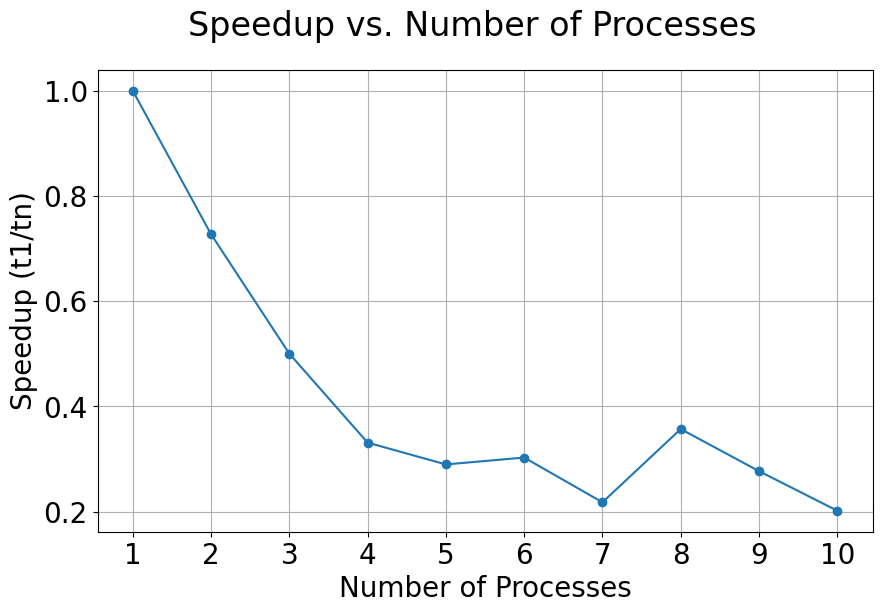

In [11]:
speedup = time_arr[0] / np.array(time_arr)

plt.plot(processes, speedup, marker='o')
plt.xticks(processes)
plt.suptitle('Speedup vs. Number of Processes')
plt.xlabel('Number of Processes')
plt.ylabel('Speedup (t1/tn)')
plt.grid(True)
plt.show()